In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def rk4_step(x, magnet_pos, t, dt, rhs):
    k1 = rhs(x, magnet_pos, t)
    k2 = rhs(x + dt / 2 * k1, magnet_pos, t + 0.5*dt)
    k3 = rhs(x + dt / 2 * k2, magnet_pos, t + 0.5*dt)
    k4 = rhs(x + dt * k3, magnet_pos, t + dt)
    
    return x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6


In [3]:
class magnet:
    def __init__(self, pos, mom):
        self.pos = np.array(pos)
        self.mom = np.array(mom)

class system:
    def __init__(self, ic, damp=0.2, moment=1, dt=0.1, t_max=100):
        self.angle = ic[0]
        self.vel = ic[1]
        self.damp = damp
        self.moment = moment
        self.dt = dt
        self.t_max = t_max
        self.num_steps = int(self.t_max / self.dt)
        self.magnets = []
        self.final_angles = []
        self.final_velocities = []
        self.equil_points = []
        
    def add_magnet(self, magnet):
        self.magnets.append(magnet)
    
    def rhs(self, x, magnets, t):
        m = 1
        g = 1
        l = 1
        mu0 = 1
        
        lagrange = -g / l * np.sin(x[0]) - self.damp * x[1]
        
        pos = np.array([np.sin(x[0]), np.cos(x[0])])
        pen_mom = self.moment * pos
        pos = l * pos
        
        if len(magnets) == 0:
            return np.array([x[1], lagrange])
        
        for magnet in magnets:
            r = pos - magnet.pos
            r_norm = np.linalg.norm(r)
            r_hat = r / r_norm
            
            lagrange += -mu0 / (4 * np.pi * m * l * r_norm**5) * (15 * np.dot(pen_mom, r_hat) * np.dot(magnet.mom, r_hat) - 3 * np.dot(pen_mom, magnet.mom)) * (r[0] * np.cos(x[0]) - r[1] * np.sin(x[0]))
            
        return np.array([x[1], lagrange])
    
    def solve(self, save=True):
        x = []
        x.append(np.array([self.angle, self.vel]))
        
        for i in range(self.num_steps - 1):
            t = (i + 1) * self.dt
            x_next = rk4_step(x[-1], self.magnets, t, self.dt, self.rhs)
            
            x.append(x_next)
        
        x = np.array(x)
        
        if save: 
            np.save("angle_list.npy", x[:, 0])
            magnets = np.array([np.concatenate([magnet.pos, magnet.mom]) for magnet in self.magnets])
            np.save("magnets.npy", magnets)
        
        self.final_angles = x[:, 0]
        self.final_velocities = x[:, 1]
        # return x
    
    def plot_solution(self, ax=None, color=None):
        if ax is None:
            _, ax = plt.subplots()
            
        ax.set_title("Solution")
        ax.set_xlabel("Time")
        ax.set_ylabel("Angle")
            
        ax.plot(np.linspace(0, self.t_max, self.num_steps), self.final_angles, color=color, alpha=0.6)
    
    def plot_phase(self, ax=None, color=None):
        if ax is None:
            _, ax = plt.subplots()
            
        ax.set_title("Phase Trajectory")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
            
        ax.plot(self.final_angles, self.final_velocities, color=color, alpha=0.6)
        
    def plot_vectorfield(self, 
            ax=None, 
            color=None, 
            num_angles=20, 
            range_angles=[-np.pi, np.pi],
            num_velolcities=20,
            range_velocities=[-4, 4]
        ):
        if ax is None:
            _, ax = plt.subplots()
        
        ax.set_title("Vector Field")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
            
        angles = np.linspace(range_angles[0], range_angles[1], num_angles)
        velocities = np.linspace(range_velocities[0], range_velocities[1], num_velolcities)
        X, Y = np.meshgrid(angles, velocities)
        
        # for magnet in self.magnets:
        #     magnet.pos = [np.ones(X.shape) * magnet.pos[0], np.ones(X.shape) * magnet.pos[1]]
        #     magnet.mom = [np.ones(X.shape) * magnet.mom[0], np.ones(X.shape) * magnet.mom[1]]
        
        # U, V = self.rhs([X, Y], self.magnets, 0)
        U = np.zeros(X.shape)
        V = np.zeros(Y.shape)
        for i, j in np.ndindex(U.shape):
            x = self.rhs([X[i, j], Y[i, j]], self.magnets, 0)
            U[i, j] = x[0]
            V[i, j] = x[1]
        
        # U, V = rk4_step([X, Y], self.magnets, 0.1, 0.1, self.rhs)
        
        # ax.streamplot(X, Y, U, V, color=color)
        q = ax.quiver(X, Y, U, V, color=color)
    
    def are_angles_equivalent(self, equil1, equil2, tol=1e-6):
        # Normalize angles to the range [-pi, pi)
        normalized_angle1 = (equil1[0] + np.pi) % (2 * np.pi) - np.pi
        normalized_angle2 = (equil2[0] + np.pi) % (2 * np.pi) - np.pi

        # Check if the normalized angles are close within the given tolerance
        angle_close = np.isclose(normalized_angle1, normalized_angle2, atol=tol)
        
        # Check if the velocity 

        # Return True if the angles are close, otherwise return False
        return angle_close
    
    def find_equil_points(self, num_points=10, tolerance=1e-6):
        equil_points = []
         
        for angle in np.linspace(-np.pi, np.pi, num_points):
            
            equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))
            #print(equillibrium)

            if np.isclose(equillibrium[1], 0.0) and not any(self.are_angles_equivalent(equillibrium, ep, tol=1e-6) for ep in equil_points):
                equil_points.append(equillibrium)
    
        self.equil_points = equil_points
    
    def plot_equil_points(self, ax=None, color=None):
        if ax is None:
            _, ax = plt.subplots()
        
        ax.set_title("Equilibrium Points")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
        
        for equil in self.equil_points:
            ax.scatter(equil[0], equil[1], color=color)


0
10


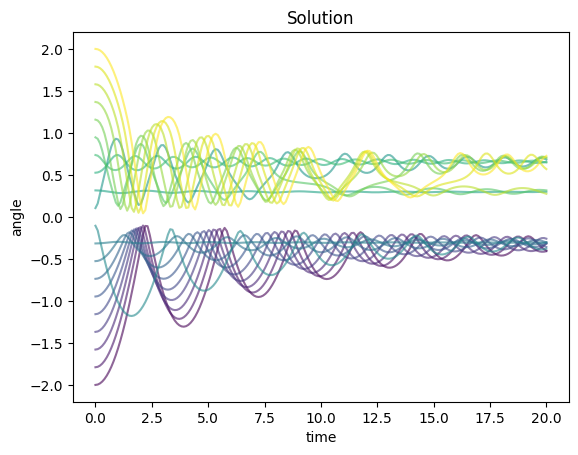

In [4]:
fig, ax = plt.subplots()

num_sims = 20
colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

for i, phi in enumerate(np.linspace(-2, 2, num_sims)):
    pendulum = system(ic=[phi, 0], t_max=20)
    pendulum.add_magnet(magnet(pos=np.array([1, 1.2]), mom=np.array([0, 1.0])))
    # pendulum.add_magnet(magnet(pos=np.array([-0.5, 1.2]), mom=np.array([0, 0.8])))
    pendulum.add_magnet(magnet(pos=np.array([0, 1.2]), mom=np.array([0, -0.1])))
    pendulum.solve()
    pendulum.plot_solution(ax, colors[i])
    if not (i) % 10:
        print(i)

ax.set_xlabel("time")
ax.set_ylabel("angle")
plt.show()


0
1
2
3
4
5
6
7
8
9


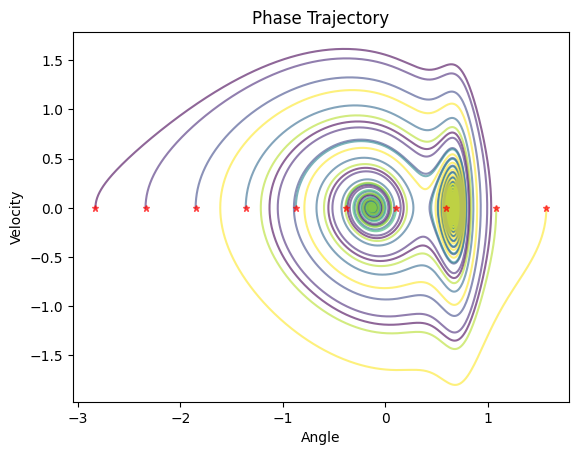

In [5]:
fig, ax = plt.subplots()

num_sims = 10
colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

ics = []
for i, phi in enumerate(np.linspace(-0.9 * np.pi, 0.5 * np.pi, num_sims)):
    ics.append([phi, 0])
    pendulum = system(ic=ics[-1], dt=0.01, t_max=50)
    pendulum.add_magnet(magnet(pos=np.array([1, 1.2]), mom=np.array([0, 1.0])))
    # pendulum.add_magnet(magnet(pos=np.array([-0.5, 1.2]), mom=np.array([0, 0.8])))
    # pendulum.add_magnet(magnet(pos=np.array([0, 1.2]), mom=np.array([0, -0.1])))
    pendulum.solve()
    pendulum.plot_phase(ax, colors[i])
    # if not (i) % 5:
    print(i)

for ic in ics:
    ax.plot(ic[0], ic[1], 'r*', markersize=5, alpha=0.6)

plt.show()


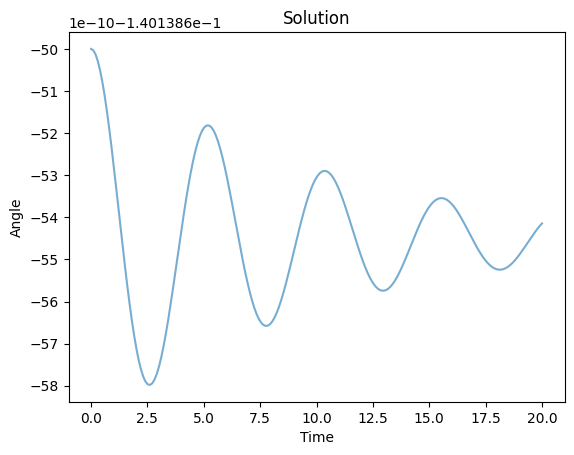

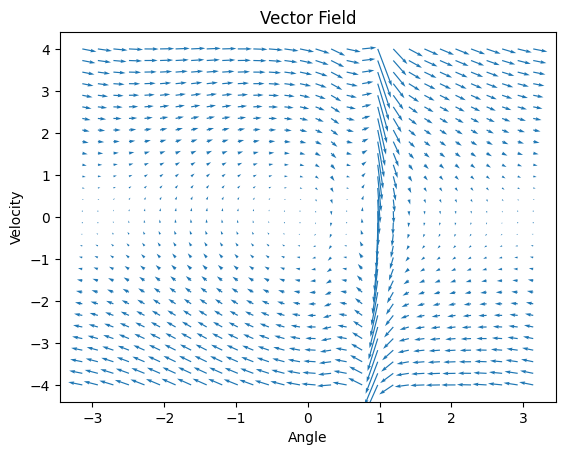

[array([-3.15472128,  0.        ]), array([-1.40138605e-01, -5.16633441e-34]), array([0.54412476, 0.        ])]


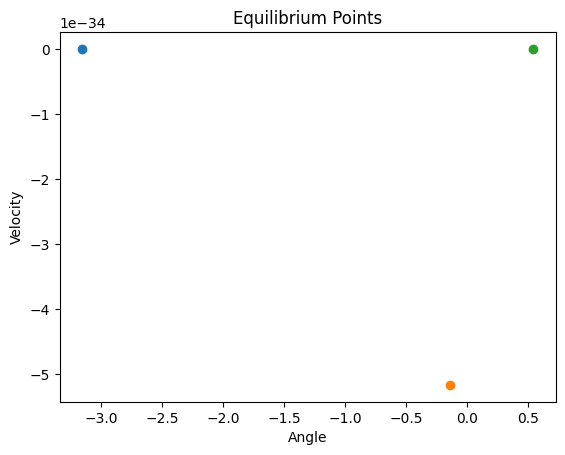

In [7]:
marcus = system(ic=[-1.40138605e-01, 0], dt=0.1, t_max=20)
# marcus = system(ic=[0.5 * np.pi, 0], dt=0.1, t_max=50)
# print(marcus.solve())
marcus.add_magnet(magnet(pos=np.array([1, 1]), mom=np.array([0.0, 1.0])))
# marcus.add_magnet(magnet(pos=np.array([-0.5, 1.2]), mom=np.array([0, 0.8])))
# marcus.add_magnet(magnet(pos=np.array([0, 1.2]), mom=np.array([0, -0.1])))


marcus.solve()
marcus.plot_solution()
# marcus.plot_phase()
marcus.plot_vectorfield(num_angles=30, num_velolcities=30)
plt.show()
marcus.find_equil_points()
marcus.plot_equil_points()

print(marcus.equil_points)

1000
(1000, 2)


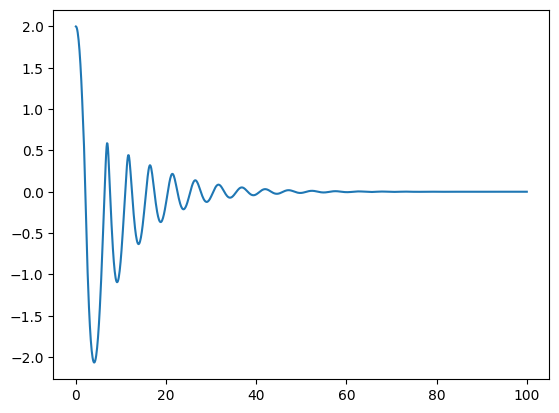

In [7]:
# def rhs(x, t):
#     return np.array([x[1], -np.sin(x[0])])

def rhs(phi, magnet_pos, t):
    m = 1
    g = 1
    l = 1
    mu0 = 1
    
    mpen = np.array([np.sin(phi[0]), np.cos(phi[0])])
    mmag = np.array([-0.5, 0])
    pos = l * mpen
    
    r = np.array(pos) - np.array(magnet_pos)
    r_norm = np.linalg.norm(r)
    r_hat = r / r_norm
    
    return np.array([
        phi[1], 
        # -np.sin(phi[0])
        - 0.2 * phi[1] - g / l * np.sin(phi[0]) - mu0 / (4 * np.pi * m * l * r_norm**5) * (15 * np.dot(mpen, r_hat) * np.dot(mmag, r_hat) - 3 * np.dot(mpen, mmag)) * (r[0] * np.cos(phi[0]) - r[1] * np.sin(phi[0]))
    ])


dt = 0.1
t_max = 100
num_steps = int(t_max / dt)
phi = []
phi.append(np.array([2, 0]))
magnet = np.array([1, 1])
# init_pos = np.linspace(-np.pi, np.pi, 100) * 0.5
# init_vel = np.zeros(100)
# phi.append([init_pos, init_vel])

for i in range(num_steps-1):
    t = (i + 1) * dt
    phi_next = rk4_step(phi[-1], magnet, t, dt, rhs)
    
    phi.append(phi_next)

phi = np.array(phi)
np.save("phi.npy", phi[:, 0])

print(num_steps)
print(phi.shape)
plt.plot(np.linspace(0, t_max, num_steps), phi[:, 0])
plt.show()
